In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import combinations
from collections import Counter
import math
from functools import partial
from tqdm import tqdm
# from p_tqdm import p_map, p_umap, p_imap, p_uimap
from multiprocessing.pool import ThreadPool as Pool
from multiprocessing import Process
import time
plt.style.use('ggplot')


In [2]:
# Check if utilities class is imported successfully
import sys
import utilities 

modulename = 'utilities'
if modulename not in sys.modules:
    print('import not successful!')

In [3]:
df = pd.read_csv('cat_w_noise.csv')
df

,x,y,class
0,17,297,0
1,18,294,0
2,18,299,0
3,19,293,0
4,19,301,0
...,...,...,...
419,191,111,0
420,192,101,0
421,192,111,0
422,193,104,0


<Axes: xlabel='x', ylabel='y'>

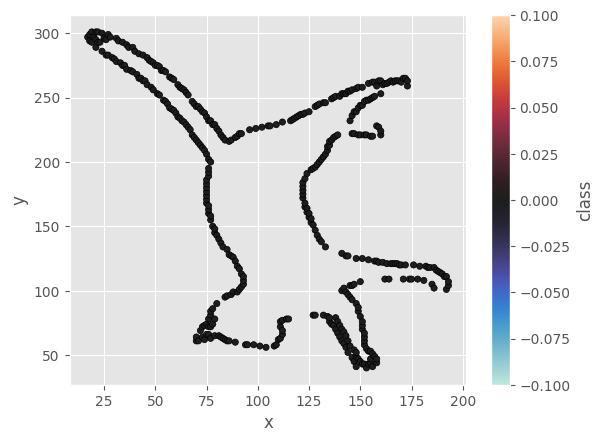

In [4]:
df.plot(x= 'x', y = 'y', c='class', kind= 'scatter', colormap= 'icefire', edgecolor='k')

In [5]:
n = 20
K = 1

# Target classifier, g: It has a array P which is the classifier computed using all points in P (hw5data.txt). 
P = df.to_numpy() 
print(f'Dataset of target classifier: {P.shape}')

temp_P = P.T

Dataset of target classifier: (424, 3)


In [6]:
# This function implements the Knn classifier by computing the euclidean distance between data points
def knn(k, predicted_x, predicted_y, pool):
    
    predicted_dp = np.array([predicted_x, predicted_y, 0.0])
    distances = predicted_dp - pool
    distances = np.power(distances, 2)
    distances = distances[:,0:2] 
    distances = np.sum(distances, axis=1)
    distances = np.sqrt(distances)
    
    vote_pool_indices = np.argsort(distances)[:k]
    vote_pool_classes = [pool[i][2] for i in vote_pool_indices]
    vote_result = Counter(vote_pool_classes).most_common()
    
    return vote_result[0][0]

In [7]:
# Create a dense 2D grid of data points 
mesh_X, mesh_Y = np.mgrid[0:1:15j,0:1:15j]

# We precompute and store target classifier to avoid recomputation
target_class_mesh = []
# for i in range(len(mesh_X)):
#     res = []
#     for j in range(len(mesh_X[0])):
#         res.append(knn(K, mesh_X[i][j], mesh_Y[i][j], P))
        
#     target_class_mesh.append(res)

for dp in P[:, :2]:
    res = knn(K, dp[0], dp[1], P)
    target_class_mesh.append(res)
    
target_class_mesh = np.array(target_class_mesh)

In [8]:
import random
random.seed(10)


# Greedy
def greedy(n_stop):
    max_N = n_stop # Size of desired teaching set
    util_obj = utilities.Utilities(max_N, K, mesh_X, mesh_Y, P, target_class_mesh)
    
    start = time.time()
    cost = 0
    best_teaching_cost = math.inf 
    curr_best_teaching_cost = math.inf 
    curr_best_teaching_set = np.array([])
    best_teaching_set = np.array([])
    searched_teaching_set_size = 0
    
    copy_P = np.copy(P)
    # Randomly pick a data point to make the teaching set's size = 1.
    idx = random.randint(0, len(copy_P)-1) 
    # Iterate over each point in the pool, and store the data point that yields the smallest disagreement function value into the teaching set   
   
    curr_D = np.array([copy_P[idx]])
    while not np.isinf(cost):
        curr_temp_best_teaching_cost = math.inf
        removed_idx = 0
        for i in range(len(copy_P)):
            searched_teaching_set_size += 1
            temp_D = np.append(curr_D, np.array([copy_P[i]]), axis=0)
            data = util_obj.disagreement_func_ex(temp_D)
            cost = data[0]
            if np.isinf(cost):
                break
            
            if cost < curr_temp_best_teaching_cost:
                curr_best_teaching_cost = cost
                curr_temp_best_teaching_cost = cost
                curr_best_teaching_set = temp_D 
                removed_idx = i
                
            if cost < best_teaching_cost:
                best_teaching_cost = cost
                best_teaching_set = temp_D 
       
        if not np.isinf(cost):
            curr_D = curr_best_teaching_set
            copy_P = np.delete(copy_P, removed_idx, axis=0)
        # print(curr_best_teaching_cost, len(curr_best_teaching_set))
   
    end = time.time()
    total_time = end - start 
    
    return curr_best_teaching_set, curr_best_teaching_cost, searched_teaching_set_size, total_time



In [9]:
def analyze_greedy(n_stop):
    list_best_teaching_set = [] 
    list_best_teaching_cost = [] 
    list_number_of_teaching_sets = [] 
    list_total_time = [] 
    for n in tqdm(range(n_stop, n_stop+1)):
        best_teaching_set, best_teaching_cost, number_of_teaching_sets, total_time = greedy(n) 
        list_best_teaching_set.append(best_teaching_set)
        list_best_teaching_cost.append(best_teaching_cost)
        list_number_of_teaching_sets.append(number_of_teaching_sets)
        list_total_time.append(total_time)
        
    return list_best_teaching_set, list_best_teaching_cost, list_number_of_teaching_sets, list_total_time
    

In [10]:
def print_analyze_greedy(n_stop, style, teaching_colors):
    
    list_best_teaching_sets, list_best_teaching_cost, list_number_of_teaching_sets, list_total_time = analyze_greedy(n_stop)
  
    ts_size = n_stop 
    for best_teaching_set in list_best_teaching_sets:
        #fig, ax = plt.subplots()
        fig = plt.figure()
        ax = fig.add_subplot(xlim=(-2.5,2.5), ylim=(-2.5,2.5))
       
        # Adding polar coordinate system
        axp = fig.add_axes(ax.get_position().bounds, polar=True, frameon=False)
        axp.set_yticklabels([]) # Removing labels
        axp.set_xticklabels([]) # Removing labels
        
        ax.set_title(f'Greedy: Teaching set data points $n$ = {ts_size} (random restarts)')
        ax.scatter(temp_P[0], temp_P[1], c=temp_P[2], cmap=style, s=20, alpha= 0.4)
        ts = best_teaching_set.T
        # plt.scatter(ts[0], ts[1], c= [teaching_colors[color] for color in ts[2]], edgecolor='k')
        size_order = 20 
        order = 0
        for dp in best_teaching_set:
            ax.scatter(dp[0], dp[1], c= teaching_colors[int(dp[2])], edgecolor='k', label= dp[2], s= size_order)
            #size_order+= 5
           
            if order < 6:
                ax.annotate(order, (dp[0], dp[1]))
            order += 1
            
        ax.set_box_aspect(1) #Print plot as a box to promote perpendicular relations
        
        ax.legend(bbox_to_anchor = (1, 1), title= "Increasing size with each addition of teaching items")
        plt.show()
        ts_size += 1
    
    
    plt.title('Greedy (N distinct runs): New teaching set size (random restarts) vs disagreement function cost')
    plt.xlabel('New teaching set size')
    plt.ylabel('Disagreement function cost')
    plt.plot(range(2, len(list_best_teaching_cost)+2), list_best_teaching_cost)
    plt.scatter(range(2, len(list_best_teaching_cost)+2), list_best_teaching_cost)
    plt.show()
    
    plt.title('Greedy (N distinct runs): New teaching set size (random restarts) vs searched teaching set size')
    plt.xlabel('New teaching set size')
    plt.ylabel('Searched teaching set size')
    plt.plot(range(2, len(list_number_of_teaching_sets)+2), list_number_of_teaching_sets)
    plt.scatter(range(2, len(list_number_of_teaching_sets)+2), list_number_of_teaching_sets)
    plt.show()
    
    plt.title('Greedy (N distinct runs): New teaching set size (random restarts) vs time elapsed (s)')
    plt.xlabel('New teaching set size')
    plt.ylabel('Time elapsed (s)')
    plt.plot(range(2, len(list_total_time)+2), list_total_time)
    plt.scatter(range(2, len(list_total_time)+2), list_total_time)
    plt.show()

In [11]:
teaching_colors = {0: 'yellow'}
#print_analyze_greedy(100, 'Dark2', teaching_colors)

In [12]:
df2 = pd.read_csv('radioactive.csv')
df2

,x,y,class
0,-0.374517,1.593652,0.0
1,0.005232,0.033719,0.0
2,0.247255,1.250794,0.0
3,-0.223085,1.894151,0.0
4,-0.171146,1.681159,0.0
...,...,...,...
595,0.626995,-0.612057,2.0
596,0.279609,-0.336777,2.0
597,0.835001,-0.871126,2.0
598,0.146948,-0.197330,2.0


<Axes: xlabel='x', ylabel='y'>

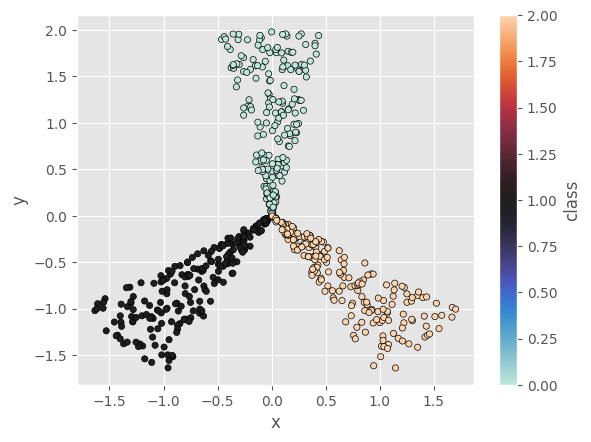

In [13]:
df2.plot(x= 'x', y = 'y', c='class', kind= 'scatter', colormap= 'icefire', edgecolor='k')

In [14]:
# Create a dense 2D grid of data points 
mesh_X, mesh_Y = np.mgrid[-4:5:15j,-3:7:15j]

n = 20
K = 1

# Target classifier, g: It has a array P which is the classifier computed using all points in P (hw5data.txt). 
P = df2.to_numpy() 
print(f'Dataset of target classifier: {P.shape}')

Dataset of target classifier: (600, 3)


In [15]:
temp_P = P.T

# We precompute and store target classifier to avoid recomputation
target_class_mesh = []
# for i in range(len(mesh_X)):
#     res = []
#     for j in range(len(mesh_X[0])):
#         res.append(knn(K, mesh_X[i][j], mesh_Y[i][j], P))
        
#     target_class_mesh.append(res)

for dp in P[:, :2]:
    res = knn(K, dp[0], dp[1], P)
    target_class_mesh.append(res)
    
target_class_mesh = np.array(target_class_mesh)

In [16]:
teaching_colors = {0: 'green', 1:'white', 2:'orange'}
# print_analyze_greedy(20, 'icefire', teaching_colors)

In [17]:
df3 = pd.read_csv('radioactive2.csv')
df3

,x,y,class
0,1.452127,0.813219,0.0
1,0.167924,0.342252,0.0
2,0.586941,0.395306,0.0
3,1.471158,0.621200,0.0
4,1.250168,1.295345,0.0
...,...,...,...
895,0.783903,-0.407438,2.0
896,0.106893,-0.243705,2.0
897,-0.057038,-0.442035,2.0
898,-0.339607,-1.603341,2.0


<Axes: xlabel='x', ylabel='y'>

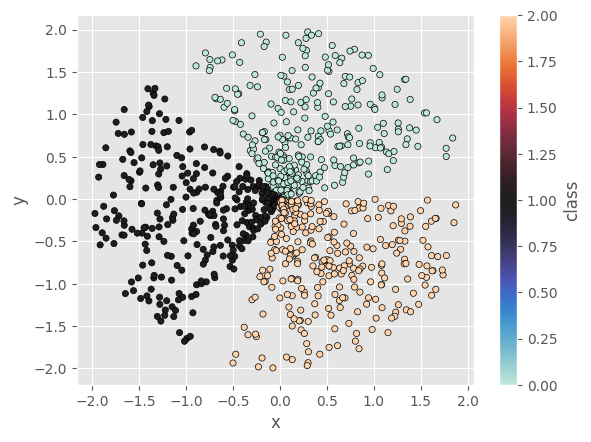

In [18]:
df3.plot(x= 'x', y = 'y', c='class', kind= 'scatter', colormap= 'icefire', edgecolor='k')

In [19]:
# Create a dense 2D grid of data points 
mesh_X, mesh_Y = np.mgrid[-4:5:15j,-3:7:15j]

n = 20
K = 1

# Target classifier, g: It has a array P which is the classifier computed using all points in P (hw5data.txt). 
P = df3.to_numpy() 
print(f'Dataset of target classifier: {P.shape}')

Dataset of target classifier: (900, 3)


In [20]:
temp_P = P.T

# We precompute and store target classifier to avoid recomputation
target_class_mesh = []
# for i in range(len(mesh_X)):
#     res = []
#     for j in range(len(mesh_X[0])):
#         res.append(knn(K, mesh_X[i][j], mesh_Y[i][j], P))
        
#     target_class_mesh.append(res)

for dp in P[:, :2]:
    res = knn(K, dp[0], dp[1], P)
    target_class_mesh.append(res)
    
target_class_mesh = np.array(target_class_mesh)

In [21]:
teaching_colors = {0: 'green', 1:'white', 2:'orange'}
#print_analyze_greedy(20, 'plasma', teaching_colors)

In [22]:
# Greedy
from scipy.spatial import Voronoi,voronoi_plot_2d 

def greedy_state_visualizer(n_stop, teaching_color):
    max_N = n_stop # Size of desired teaching set
    util_obj = utilities.Utilities(max_N, K, mesh_X, mesh_Y, P, P[:,2:])
   
    
    # Picks an arbitrary start point
    idx = random.randint(0, len(util_obj.pool_P)-1) 
    
    local_best_teaching_dp_set = []
   
    local_best_teaching_dp_set.append(util_obj.pool_P[idx]) # Append the first datapoint for teaching set 
    local_best_teaching_dp_set = np.array(local_best_teaching_dp_set) # (1,2) array with one teaching point
    print(local_best_teaching_dp_set)
    
    # Calculate cost for the current teaching set
    cost, teaching_set, classifier_results = util_obj.disagreement_func_ex(local_best_teaching_dp_set)
    
    # Printing and plotting point
    fig, ax = plt.subplots(1,1)
    ax.set_title(f'Greedy: n = {len(local_best_teaching_dp_set)}, cost = {cost}')
    ax.set_box_aspect(1)
    ax.scatter(util_obj.pool_P.T[0], util_obj.pool_P.T[1], c =[teaching_color[c] for c in classifier_results])
    ax.scatter(local_best_teaching_dp_set.T[0],local_best_teaching_dp_set.T[1], marker='x')
    plt.savefig(f'./greedy_results/greedy_one_run_n_{len(local_best_teaching_dp_set)}')
    plt.show()
    
   
    # Declare variables
    temp_cost = cost # temporary cost 
    
    local_best_cost = np.inf # best cost
    local_best_next_teaching_dp_set = None
    local_best_classifier_results = None
    
    list_of_best_costs = np.array([cost])
    
    # Teaching point selection
    # Loops till our disagreement function returns infinity, signalling we have reach teaching set capacity
    while not np.isinf(temp_cost):
        
        # Iterate all data points in pool, to select best next teaching point
        for data_point in util_obj.pool_P:
            temp_probe_teaching_set = np.append(local_best_teaching_dp_set, [data_point], axis = 0)
            
            # Find the cost, and classifier results after the addition of datapoint
            temp_cost, teaching_set, classifier_results = util_obj.disagreement_func_ex(temp_probe_teaching_set)
            
            if np.isinf(temp_cost):
                break
           
            # Store metadata for teaching set that generates the minimum cost 
            if temp_cost < local_best_cost:
                local_best_cost = temp_cost
                local_best_next_teaching_dp_set = temp_probe_teaching_set
                local_best_classifier_results = classifier_results
       
        if np.isinf(temp_cost):
            break
        
        # once for loop is left, we will have the best local minimums
        local_best_teaching_dp_set = local_best_next_teaching_dp_set
        list_of_best_costs = np.append(list_of_best_costs, [local_best_cost], axis = 0)
        
        
        
        # Printing and plotting point
        fig, ax = plt.subplots(1,1)
        
        # Draw voronoi
        if len(local_best_teaching_dp_set[:,:2]) >= 3:
            vor = Voronoi(local_best_teaching_dp_set[:,:2])
            fig = voronoi_plot_2d(vor, ax)
        
        ax.set_title(f'Greedy: n = {len(local_best_teaching_dp_set)}, cost = {local_best_cost}')
        ax.set_box_aspect(1)
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)
        ax.scatter(util_obj.pool_P.T[0], util_obj.pool_P.T[1], c =[teaching_color[c] for c in local_best_classifier_results])
        ax.scatter(local_best_teaching_dp_set.T[0],local_best_teaching_dp_set.T[1], marker='x')
        
        
        plt.savefig(f'./greedy_results_d3/greedy_one_run_n_{len(local_best_teaching_dp_set)}')
        plt.show()
        
        # Once for loop is left, all local variables should be reset
        local_best_cost = np.inf
        
    
    return None

[[-0.15790933 -0.26229987  1.        ]]


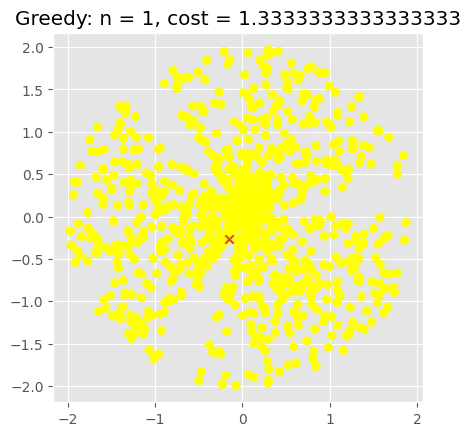

KeyError: 2

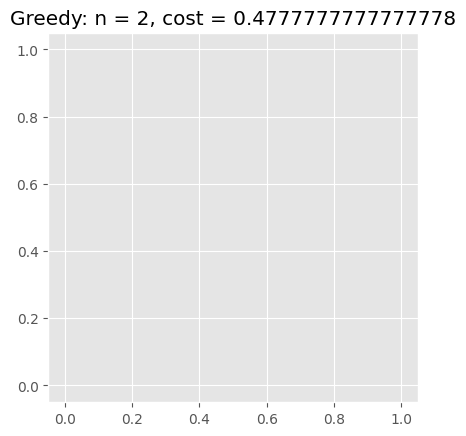

In [23]:
teaching_color = {0: 'indigo', 1: 'yellow'}
#greedy_state_visualizer(20, teaching_color)

# Note: write code for new datasets here!